In [1]:
### importing all required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings 
import joblib

In [3]:
### importing classfication needed labraries

In [4]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [5]:
### Read and analyse the dataset

In [6]:
df=pd.read_csv("predictive_maintenance.csv")

In [7]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [10]:
### drop unnecessary columns which means that does not effect the output

In [11]:
df.drop(['UDI','Product ID','Failure Type'],axis=1,inplace=True)

In [12]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [13]:
### encode the type column[categorical to numerical] 

In [14]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [15]:
### as it has only 3 unique variables so we can use label encoder here

In [16]:
le=LabelEncoder()
df['Type']=le.fit_transform(df['Type']) #L=1,M=2,H=3

In [17]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0


In [18]:
###Feature Engineering which means adding some additional data to the dataset.

In [19]:
df['Tor*Toolwear']=df['Tool wear [min]'] * df['Torque [Nm]']
df['temp_diff']=df['Process temperature [K]']-df['Air temperature [K]']
df['power [rps]']=df['Rotational speed [rpm]'] * df['Torque [Nm]'] * 0.0166

In [20]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Tor*Toolwear,temp_diff,power [rps]
0,2,298.1,308.6,1551,42.8,0,0,0.0,10.5,1101.95448
1,1,298.2,308.7,1408,46.3,3,0,138.9,10.5,1082.16064
2,1,298.1,308.5,1498,49.4,5,0,247.0,10.4,1228.41992
3,1,298.2,308.6,1433,39.5,7,0,276.5,10.4,939.61810
4,1,298.2,308.7,1408,40.0,9,0,360.0,10.5,934.91200


In [21]:
### saving the modified dataset

In [22]:
df.to_csv("Modified_predictive_maintenance.csv",index=False)

In [23]:
### visualisations

C:\Users\yvsya\AppData\Local\Temp\ipykernel_7112\4127389725.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data=df,x='Target',palette='Set2')


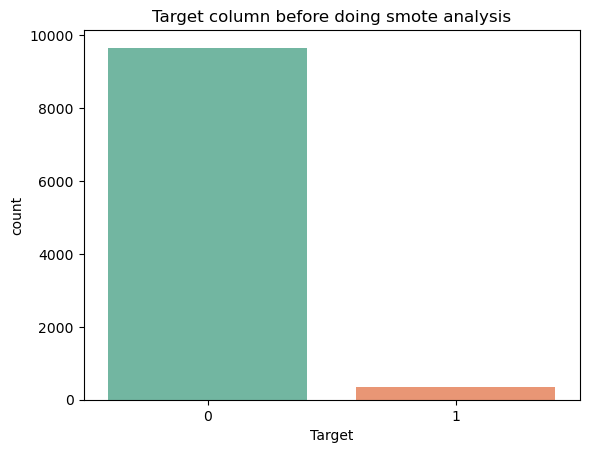

In [24]:
plt.Figure(figsize=(8,4))
sb.countplot(data=df,x='Target',palette='Set2')
plt.title("Target column before doing smote analysis")
plt.show() ### the data is in imbalance

In [25]:
warnings.filterwarnings("ignore")

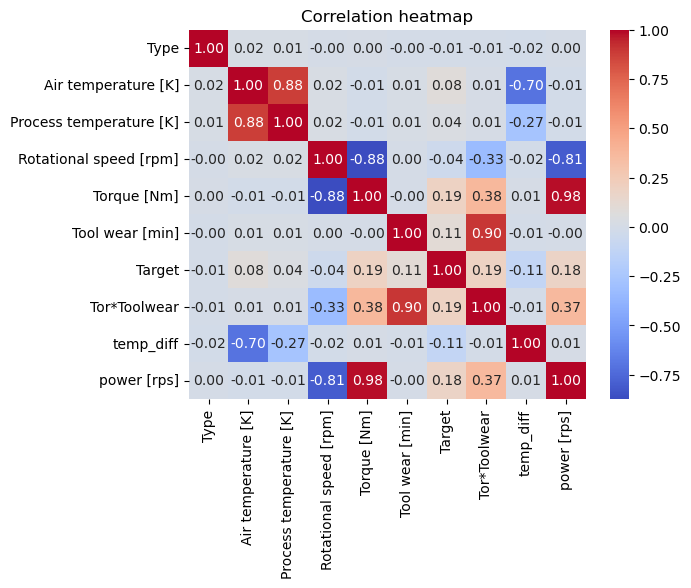

In [26]:
### visualising all dependencies using correlation heatmap
plt.Figure(figsize=(8,4))
sb.heatmap(df.corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title("Correlation heatmap")
plt.show()

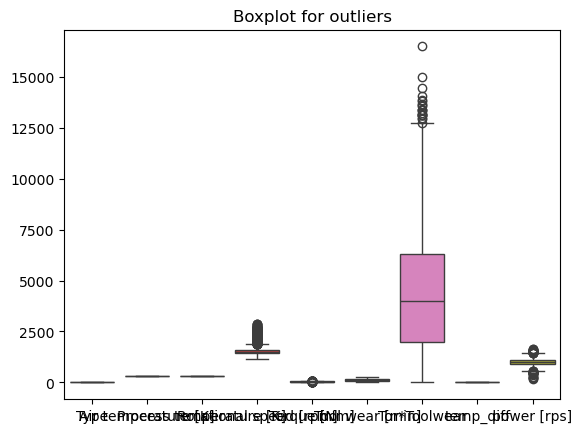

In [27]:
### Box plot for detecting outliers
plt.Figure(figsize=(8,20))
sb.boxplot(data=df.drop(columns=['Target']))
plt.title("Boxplot for outliers")
plt.show()

In [28]:
### Applying inter quartile outlier handling

In [29]:
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] > upper, upper,
                           np.where(df[col] < lower, lower, df[col]))
    return df
    
iqr_columns = [
    'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
    'Tor*Toolwear', 'temp_diff', 'power [rps]'
]
df = cap_outliers_iqr(df, iqr_columns)

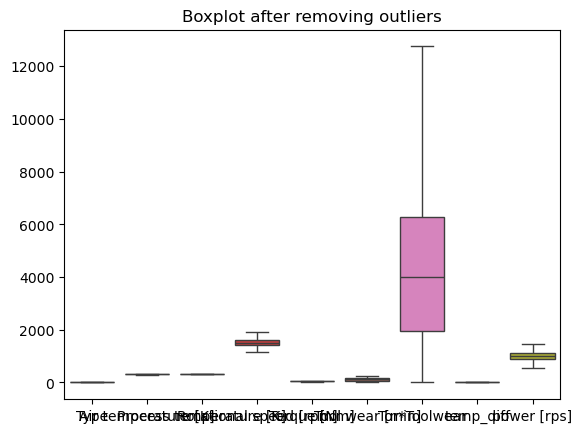

In [30]:
plt.Figure(figsize=(8,20))
sb.boxplot(data=df.drop(columns=['Target']))
plt.title("Boxplot after removing outliers")
plt.show()

In [31]:
### splitting feature and target as independent and dependent variables

In [32]:
x=df.drop('Target',axis=1)
y=df['Target']

In [33]:
###Apply scaling

In [34]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

In [35]:
### Applying SMOTE to balance the target class

In [36]:
sm=SMOTE(random_state=0)
x_smoted,y_smoted=sm.fit_resample(x_scaled,y)

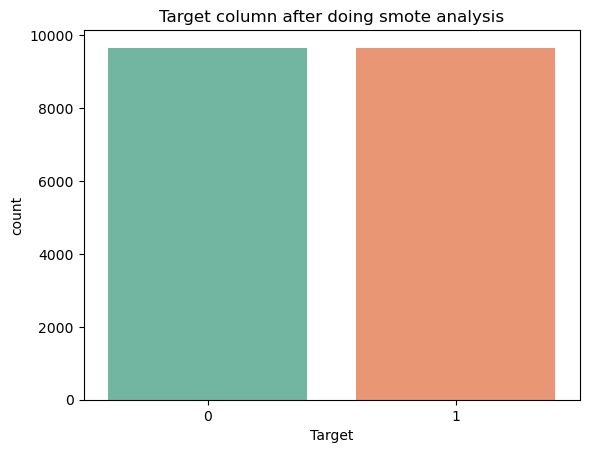

In [37]:

plt.Figure(figsize=(8,4))
sb.countplot(x=y_smoted,palette='Set2')
plt.title("Target column after doing smote analysis")
plt.show()

In [38]:
### Split for training and testing the data

In [39]:
x_train,x_test,y_train,y_test=train_test_split(x_smoted,y_smoted,test_size=0.2,random_state=0)

In [40]:
### Decision Tree Model

In [46]:
model_1=DecisionTreeClassifier()
model_1.fit(x_train,y_train)
y_pred1=model_1.predict(x_test)
print(classification_report(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1919
           1       0.97      0.97      0.97      1946

    accuracy                           0.97      3865
   macro avg       0.97      0.97      0.97      3865
weighted avg       0.97      0.97      0.97      3865

[[1866   53]
 [  54 1892]]


In [42]:
### RandomForest model

In [47]:
model_2=RandomForestClassifier()
model_2.fit(x_train,y_train)
y_pred2=model_2.predict(x_test)
print(classification_report(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1919
           1       0.98      0.99      0.98      1946

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865

[[1873   46]
 [  23 1923]]


In [44]:
### XGBoost model

In [48]:
model_3=XGBClassifier(use_label_encoder=False,eval_metrix='logloss')
model_3.fit(x_train,y_train)
y_pred3=model_3.predict(x_test)
print(classification_report(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1919
           1       0.98      0.99      0.99      1946

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865

[[1884   35]
 [  15 1931]]


In [49]:
preds=[y_pred1,y_pred2,y_pred3]
names=['Decision Tree','Random Forest','XGBoost']
mapcolor=['Blues','Oranges','Greens']

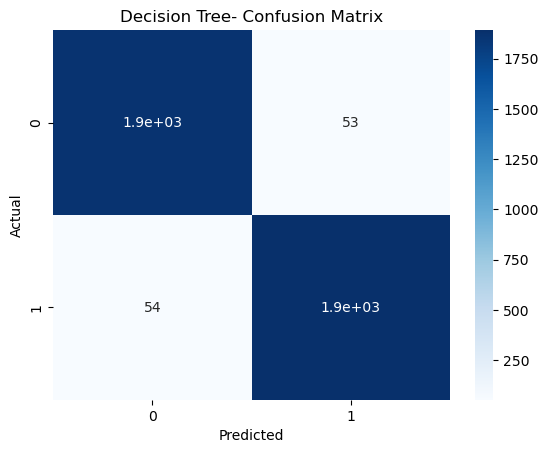

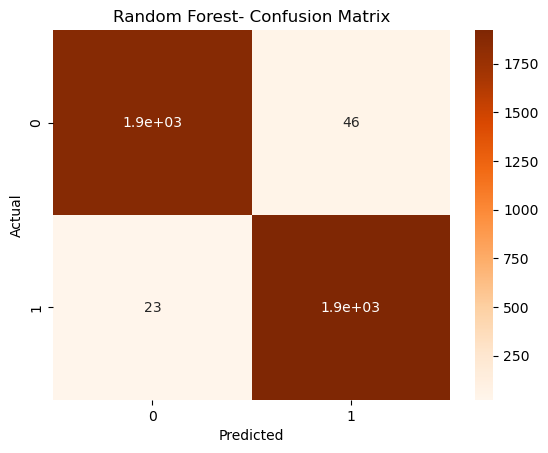

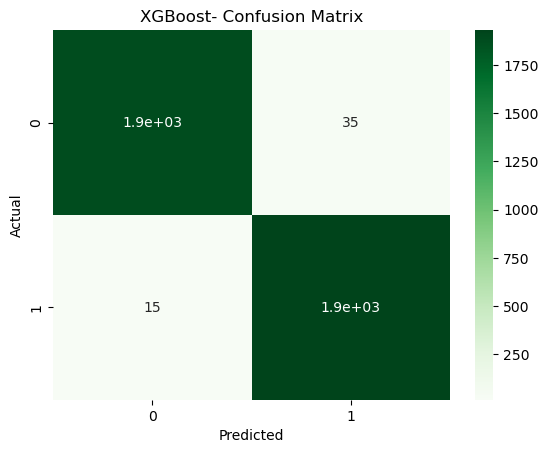

In [50]:
for i in range(3):
    cm=confusion_matrix(y_test,preds[i])
    plt.Figure(figsize=(5,4))
    sb.heatmap(cm,annot=True,cmap=mapcolor[i],xticklabels=[0,1],yticklabels=[0,1])
    plt.title(f"{names[i]}- Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [52]:
### ROC Curve for comparing

In [58]:
y_probs=[model_1.predict_proba(x_test)[:,1],model_2.predict_proba(x_test)[:,1],model_3.predict_proba(x_test)[:,1]]
names=['Decision Tree','Random Forest','XGBoost']
linecolor=['blue','orange','green']

In [59]:
from sklearn.metrics import roc_curve,auc

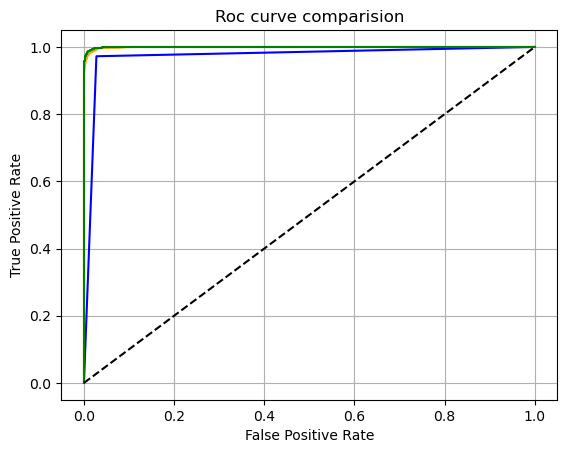

In [60]:
plt.Figure(figsize=(8,6))
for i in range(3):
    fpr,tpr,_=roc_curve(y_test,y_probs[i])
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,color=linecolor[i],label=f"{names[i]}(AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--',label="Random Guess")
plt.title("Roc curve comparision")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

In [61]:
### so from above roc curve and confusion matrix we can say that XGBoost is the best model 

In [62]:
### saving the model to deploy

In [63]:
joblib.dump(model_3,"XGBoost_model.joblib")

['XGBoost_model.joblib']

In [64]:
joblib.dump(scaler,"scaler.joblib")

['scaler.joblib']

In [65]:
### testing the model by giving some input features

In [66]:
model=joblib.load("XGBoost_model.joblib")
scaler=joblib.load("scaler.joblib")
sample_input_1=np.array([[2, 300.0, 320.0, 1800.0, 85.0, 220.0, 85.0*220.0, 20.0, 1800.0*85.0*0.0166]])
sample_input_2=np.array([[2, 300.0, 310.0, 1500.0, 50.0, 30.0, 1500.0, 10.0, 1245.0]])
sample=[sample_input_1,sample_input_2]
for i in range(2):
    scaled_input=scaler.transform(sample[i])
    prediction=model.predict(scaled_input)[0]
    print("Prediction:", "Failure Detected" if prediction == 1 else "No Failure Detected")

Prediction: Failure Detected
Prediction: No Failure Detected


In [1]:
### To direct the path where all files are saved we need to use os library

In [2]:
import os
print(os.getcwd())

C:\Users\yvsya


In [ ]:
### copy the above link and paste it in the filmanager search bar we will find all our saved f